<a href="https://colab.research.google.com/github/hieuhannguyen/titanic/blob/main/TitanicPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Analysis**
- Load the datasets
- Perform merge/concat if necessary
- Assess their shapes
- Assess nulls

In [1]:
#%pip install prince

In [2]:
# importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Importing preprocessing and encoding libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.target import ClassBalance

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from yellowbrick.classifier import ROCAUC

# Importing PCA for dimensionality reduction
# from prince import FAMD
from yellowbrick.features import PCA as PCA_viz

# Importing class balance tools for handling imbalanced datasets
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [3]:
#loading in the prompts
data_train = pd.read_csv('/content/train.csv')
data_test = pd.read_csv('/content/test.csv')

data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#data to train
data_train.shape

(891, 12)

In [5]:
#data for submission
data_test.shape

(418, 11)

In [6]:
#merging these datasets into one for cleaning and preprocessing
data = pd.concat([data_train, data_test], axis=0, ignore_index=True)
data.tail() #checking the last index to be 891+418-1 = 1308

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [7]:
#checking for nulls
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [8]:
# calculate percentage of nulls
data.isnull().mean() * 100

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64

# **Cleaning**
- Tackle 'Name', 'Ticket', & 'Cabin' columns: These features contain text data that cannot be quickly processed for machine learning. We must analyze each feature and find a suitable approach.
- Handle nulls for 'Cabin', 'Age', 'Embarked, & 'Fare': We can find a quick imputation method for 'Embarked' (missing 2 values) and 'Fare' (missing 1 value), but we must analyze and figure out a robust method for dealing with 'Cabin' (missing 77.46%) and 'Age' (missing 20.09%).

## 'Name'
This feature can be valuable if we can extract the title and the last name. Relying on common sense, we can expect one's title to be helpful in identifying one's age and priority to be rescued on the ship. It also might be interesting to see if certain last names are more likely to survive than others. First names are too personal and randomly chosen to be helpful.

In [9]:
# Extract Last Name
data['Last Name'] = data['Name'].apply(lambda x: x.split(',')[0])

# Extract First Name
data['First Name'] = data['Name'].apply(lambda x: x.split(',')[1])

# Extract Title
data['Title'] = data['First Name'].apply(lambda x: x.split('.')[0])

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs. Jacques Heath (Lily May Peel),Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr. William Henry,Mr


## 'Ticket'
Quick observation allows us to see two parts of a ticket: a suffix and a prefix separated by a white space. Some ticket code has three parts as well, but we will consider the last str after splitting by a whitespace to be a suffix. From there, the remaining str is the prefix. Let's observe each part of the ticket individually to identify a way to encode them.

In [10]:
# Extract Suffix from Ticket
data['Tix_Suffix'] = data['Ticket'].apply(lambda x: x.split(' ')[-1])
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris,Mr,21171
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs,17599
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina,Miss,3101282
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs. Jacques Heath (Lily May Peel),Mrs,113803
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr. William Henry,Mr,373450


In [11]:
# Function to extract prefix based on suffix
def extract_prefix(ticket, suffix):
    return ticket.replace(suffix, '').strip()

data['Tix_Prefix'] = data.apply(lambda row: extract_prefix(row['Ticket'], row['Tix_Suffix']), axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris,Mr,21171,A/5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs,17599,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina,Miss,3101282,STON/O2.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs. Jacques Heath (Lily May Peel),Mrs,113803,
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr. William Henry,Mr,373450,


In [12]:
#Observe different prefix values, note the empty '' value
data['Tix_Prefix'].unique()

array(['A/5', 'PC', 'STON/O2.', '', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O 2.', 'A4.', 'C',
       'SOTON/O.Q.', 'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.',
       'W/C', 'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S',
       'SC/AH Basle', 'A/4', 'WE/P', 'S.W./PP', 'S.O./P.P.', 'F.C.',
       'SOTON/O2', 'S.C./PARIS', 'C.A./SOTON', 'SC/A.3', 'STON/OQ.',
       'SC/A4', 'AQ/4', 'A. 2.', 'LP', 'AQ/3.'], dtype=object)

In [13]:
# replace the '' into 'NAN' -- just good practice
data['Tix_Prefix'] = data['Tix_Prefix'].replace('','NAN')

In [14]:
#closer look at the suffixes, they seem to be in the type of numerical, but previous attempt showed that some are not in the right type
data['Tix_Suffix'].nunique()

924

In [15]:
#find non-numerical suffixes
data[~data['Tix_Suffix'].astype(str).apply(lambda x: x.isdigit())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Leonard,Mr. Lionel,Mr,LINE,NAN
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Tornquist,Mr. William Henry,Mr,LINE,NAN
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Johnson,Mr. William Cahoone Jr,Mr,LINE,NAN
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Johnson,Mr. Alfred,Mr,LINE,NAN


In [16]:
# replace LINE with a unique numerical-like value
data['Tix_Suffix'] = data['Tix_Suffix'].replace('LINE', '-1')

data[data['Tix_Suffix'] == '-1']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Leonard,Mr. Lionel,Mr,-1,NAN
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Tornquist,Mr. William Henry,Mr,-1,NAN
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Johnson,Mr. William Cahoone Jr,Mr,-1,NAN
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Johnson,Mr. Alfred,Mr,-1,NAN


In [17]:
#make suffixes numerical
data['Tix_Suffix'] = data['Tix_Suffix'].astype(int)

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris,Mr,21171,A/5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs,17599,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina,Miss,3101282,STON/O2.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs. Jacques Heath (Lily May Peel),Mrs,113803,NAN
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr. William Henry,Mr,373450,NAN


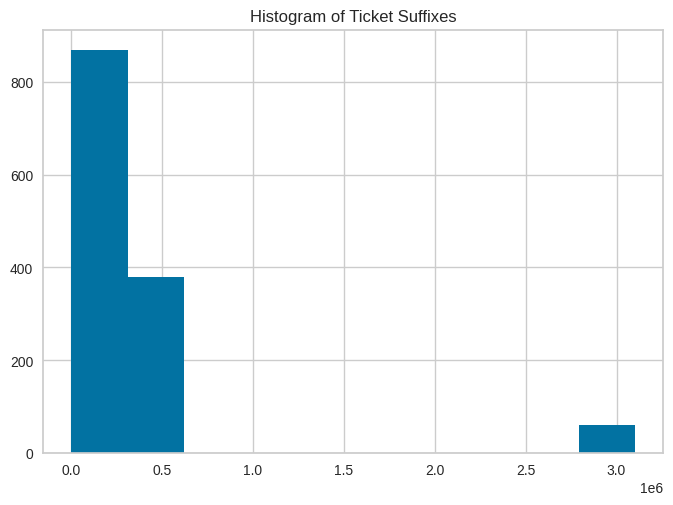

In [18]:
#what does the data look like when sorted by suffixes, note the big gap between the bars which can indicate a gap in our sorted list
data['Tix_Suffix'].sort_values().hist()
plt.title('Histogram of Ticket Suffixes')
plt.show()

In [19]:
#finding that cut-off between 0.5*1e6 and 3.0*1e6--implies that suffixes are categorical instead of numerical
temp = data['Tix_Suffix'].sort_values().to_list()
temp[1235:1265]

[392078,
 392082,
 392083,
 392086,
 392087,
 392089,
 392090,
 392091,
 392091,
 392092,
 392095,
 392096,
 392096,
 394140,
 3101262,
 3101263,
 3101264,
 3101265,
 3101266,
 3101267,
 3101268,
 3101269,
 3101270,
 3101271,
 3101272,
 3101273,
 3101274,
 3101275,
 3101276,
 3101277]

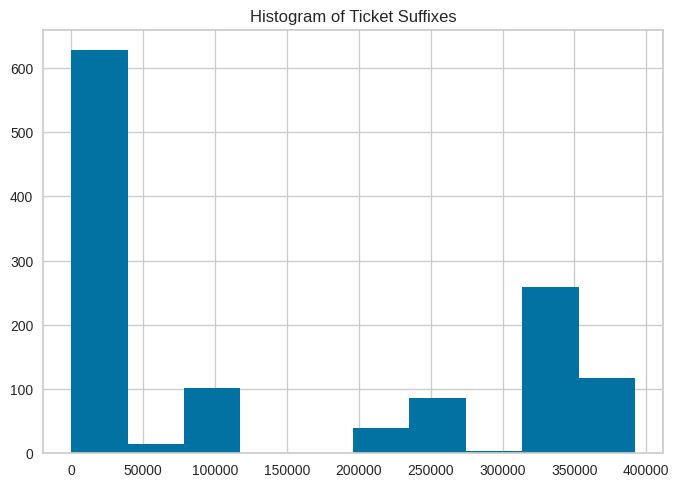

In [20]:
#Zoom in past the cut-off to double check if there are other gaps
data['Tix_Suffix'].sort_values().head(temp.index(394140)).hist()
plt.title('Histogram of Ticket Suffixes')
plt.show()

In [21]:
#finding that second gap between 100,000 and 200,000
temp[635:650]

[49867,
 54510,
 54636,
 54636,
 65303,
 65304,
 65305,
 65306,
 110152,
 110152,
 110152,
 110413,
 110413,
 110413,
 110465]

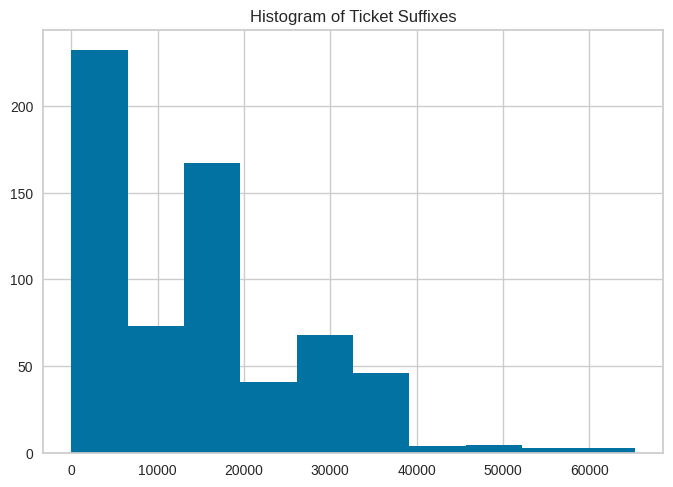

In [22]:
#Zoom in past the cut-off
data['Tix_Suffix'].sort_values().head(temp.index(65306)).hist()
plt.title('Histogram of Ticket Suffixes')
plt.show()

In [23]:
# re-categorizing ticket suffixes -- for convenience, I'm also encoding the suffixes here
suffix_type = {
    -1 : 0,
    10: 1,
    1000: 2,
    10000: 3,
    20000: 4,
    100000: 5,
    400000: 6,
    4000000: 7
}

In [24]:
# greedy algorithm to encode the suffix
data['Suffix_enc'] = data['Tix_Suffix'].apply(lambda x: next((v for k, v in suffix_type.items() if x < k), 0))

data.sample(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix,Suffix_enc
126,127,0.0,3,"McMahon, Mr. Martin",male,NaN,0,0,370372,7.7500,NaN,Q,McMahon,Mr. Martin,Mr,370372,NAN,6
1091,1092,NaN,3,"Murphy, Miss. Nora",female,NaN,0,0,36568,15.5000,NaN,Q,Murphy,Miss. Nora,Miss,36568,NAN,5
84,85,1.0,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S,Ilett,Miss. Bertha,Miss,14885,SO/C,4
1239,1240,NaN,2,"Giles, Mr. Ralph",male,24.0,0,0,248726,13.5000,NaN,S,Giles,Mr. Ralph,Mr,248726,NAN,6
521,522,0.0,3,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,Vovk,Mr. Janko,Mr,349252,NAN,6


## 'Cabin'
This column has the most missing values. It seems a regular cabin code contains a letter and a str of numbers. The letter might indicate the deck area on the Titanic (see note 2), which might be crucial in identifying who lived and who did not. We will try to retain this column through extracting the deck code.

In [25]:
#observe unique cabin values, note that most codes are made of one letter and some numbers with outliers where there are more than one code.
data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [26]:
# Fill all nans with 'Z' -- a substitute for a cabin name
data['Cabin'] = data['Cabin'].fillna('Z')

In [27]:
# Add a row to note imputation -- good practice
data['Impute Cabin?'] = data['Cabin'].apply(lambda x: 1 if x == 'Z' else 0)
data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix,Suffix_enc,Impute Cabin?
1182,1183,NaN,3,"Daly, Miss. Margaret Marcella Maggie""""",female,30.0,0,0,382650,6.9500,Z,Q,Daly,"Miss. Margaret Marcella Maggie""""",Miss,382650,NAN,6,1
1162,1163,NaN,3,"Fox, Mr. Patrick",male,NaN,0,0,368573,7.7500,Z,Q,Fox,Mr. Patrick,Mr,368573,NAN,6,1
867,868,0.0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S,Roebling,Mr. Washington Augustus II,Mr,17590,PC,4,0
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,Z,S,Cunningham,Mr. Alfred Fleming,Mr,239853,NAN,6,1
168,169,0.0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,Z,S,Baumann,Mr. John D,Mr,17318,PC,4,1
1262,1263,NaN,1,"Wilson, Miss. Helen Alice",female,31.0,0,0,16966,134.5000,E39 E41,C,Wilson,Miss. Helen Alice,Miss,16966,NAN,4,0
662,663,0.0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S,Colley,Mr. Edward Pomeroy,Mr,5727,NAN,3,0
1022,1023,NaN,1,"Gracie, Col. Archibald IV",male,53.0,0,0,113780,28.5000,C51,C,Gracie,Col. Archibald IV,Col,113780,NAN,6,0
308,309,0.0,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.0000,Z,C,Abelson,Mr. Samuel,Mr,3381,P/PP,3,1
451,452,0.0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,Z,S,Hagland,Mr. Ingvald Olai Olsen,Mr,65303,NAN,5,1


In [28]:
# check out all records with 2 or more cabin codes, note that except for 'F' records, they all have the same letters
data.loc[data['Cabin'].str.split().apply(len) >= 2,'Cabin']

27          C23 C25 C27
75                F G73
88          C23 C25 C27
97              D10 D12
118             B58 B60
128               F E69
297             C22 C26
299             B58 B60
305             C22 C26
311     B57 B59 B63 B66
341         C23 C25 C27
390             B96 B98
435             B96 B98
438         C23 C25 C27
498             C22 C26
679         B51 B53 B55
699               F G63
700             C62 C64
715               F G73
742     B57 B59 B63 B66
763             B96 B98
789             B82 B84
802             B96 B98
872         B51 B53 B55
915     B57 B59 B63 B66
944         C23 C25 C27
948               F G63
955     B57 B59 B63 B66
960         C23 C25 C27
972             C55 C57
1005            C55 C57
1033    B57 B59 B63 B66
1075            B58 B60
1093            C62 C64
1179              F E46
1197            C22 C26
1212              F E57
1234        B51 B53 B55
1241            D10 D12
1262            E39 E41
1263        B52 B54 B56
Name: Cabin, dty

In [29]:
#removing the 'F ' string for unique cabins such as 'F E46' to obtain only the second unique identifier
data.loc[data['Cabin'].str.split().apply(len) >= 2,'Cabin'] = \
data[data['Cabin'].str.split().apply(len) >= 2]['Cabin'].apply(lambda x: x.replace('F ',''))

In [30]:
# double check results
data.loc[data['Cabin'].str.split().apply(len) >= 2,'Cabin']

27          C23 C25 C27
88          C23 C25 C27
97              D10 D12
118             B58 B60
297             C22 C26
299             B58 B60
305             C22 C26
311     B57 B59 B63 B66
341         C23 C25 C27
390             B96 B98
435             B96 B98
438         C23 C25 C27
498             C22 C26
679         B51 B53 B55
700             C62 C64
742     B57 B59 B63 B66
763             B96 B98
789             B82 B84
802             B96 B98
872         B51 B53 B55
915     B57 B59 B63 B66
944         C23 C25 C27
955     B57 B59 B63 B66
960         C23 C25 C27
972             C55 C57
1005            C55 C57
1033    B57 B59 B63 B66
1075            B58 B60
1093            C62 C64
1197            C22 C26
1234        B51 B53 B55
1241            D10 D12
1262            E39 E41
1263        B52 B54 B56
Name: Cabin, dtype: object

In [31]:
# take out the deck name from the cabin number, see note 2
data['Deck'] = data['Cabin'].apply(lambda x: x[0])
data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix,Suffix_enc,Impute Cabin?,Deck
291,292,1.0,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C,Bishop,Mrs. Dickinson H (Helen Walton),Mrs,11967,NAN,4,0,B
513,514,1.0,1,"Rothschild, Mrs. Martin (Elizabeth L. Barrett)",female,54.0,1,0,PC 17603,59.4000,Z,C,Rothschild,Mrs. Martin (Elizabeth L. Barrett),Mrs,17603,PC,4,1,Z
640,641,0.0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,Z,S,Jensen,Mr. Hans Peder,Mr,350050,NAN,6,1,Z
871,872,1.0,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S,Beckwith,Mrs. Richard Leonard (Sallie Monypeny),Mrs,11751,NAN,4,0,D
388,389,0.0,3,"Sadlier, Mr. Matthew",male,NaN,0,0,367655,7.7292,Z,Q,Sadlier,Mr. Matthew,Mr,367655,NAN,6,1,Z
581,582,1.0,1,"Thayer, Mrs. John Borland (Marian Longstreth M...",female,39.0,1,1,17421,110.8833,C68,C,Thayer,Mrs. John Borland (Marian Longstreth Morris),Mrs,17421,NAN,4,0,C
273,274,0.0,1,"Natsch, Mr. Charles H",male,37.0,0,1,PC 17596,29.7000,C118,C,Natsch,Mr. Charles H,Mr,17596,PC,4,0,C
154,155,0.0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,Z,S,Olsen,Mr. Ole Martin,Mr,265302,Fa,6,1,Z
812,813,0.0,2,"Slemen, Mr. Richard James",male,35.0,0,0,28206,10.5000,Z,S,Slemen,Mr. Richard James,Mr,28206,NAN,5,1,Z
685,686,0.0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,Z,C,Laroche,Mr. Joseph Philippe Lemercier,Mr,2123,SC/Paris,3,1,Z


## 'Age'
Age is the most difficult to handle because it is very much continuous. We can rely on some clues to impute a reasonable age for missing values from one's title and domain knowledge of population average age for different group of people at the time.

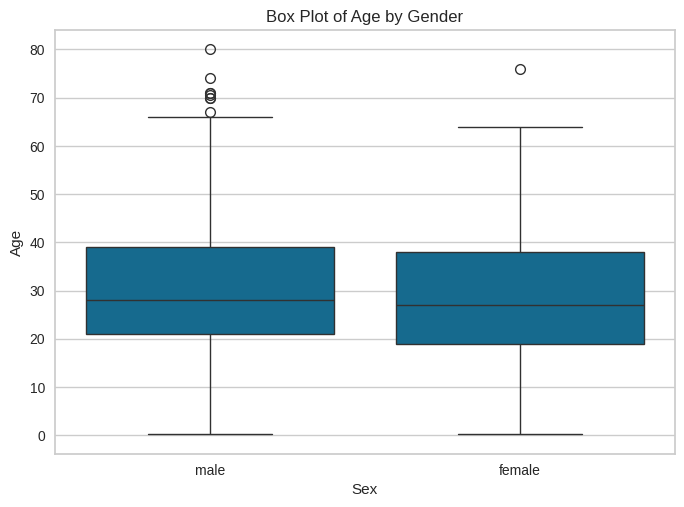

In [32]:
#observing the age of passenger to determine an appropriate imputation strategy
sns.boxplot(x="Sex", y="Age", data=data).set(title='Box Plot of Age by Gender')
plt.show()

In [33]:
# what is the mean age of men and women on the Titanic
mean_age_male = data[data['Sex'] == 'male']['Age'].mean()
print(f"Mean age for male passengers: {mean_age_male}")

mean_age_female = data[data['Sex'] == 'female']['Age'].mean()
print(f"Mean age for female passengers: {mean_age_female}")

Mean age for male passengers: 30.58522796352584
Mean age for female passengers: 28.68708762886598


In [34]:
#title gives us some hints of age
data['Title'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [35]:
#unique titles of all NaN Age rows
data[data['Age'].isnull()==True]['Title'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Dr', ' Ms'], dtype=object)

In [36]:
#ensure there is a column to note imputation
data['Impute Age?'] = data['Age'].apply(lambda x: 1 if pd.isna(x) else 0)
data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix,Suffix_enc,Impute Cabin?,Deck,Impute Age?
206,207,0.0,3,"Backstrom, Mr. Karl Alfred",male,32.00,1,0,3101278,15.8500,...,S,Backstrom,Mr. Karl Alfred,Mr,3101278,NAN,7,1,Z,0
612,613,1.0,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,...,Q,Murphy,Miss. Margaret Jane,Miss,367230,NAN,6,1,Z,1
312,313,0.0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.00,1,1,250651,26.0000,...,S,Lahtinen,Mrs. William (Anna Sylfven),Mrs,250651,NAN,6,1,Z,0
1103,1104,NaN,2,"Deacon, Mr. Percy William",male,17.00,0,0,S.O.C. 14879,73.5000,...,S,Deacon,Mr. Percy William,Mr,14879,S.O.C.,4,1,Z,0
526,527,1.0,2,"Ridsdale, Miss. Lucy",female,50.00,0,0,W./C. 14258,10.5000,...,S,Ridsdale,Miss. Lucy,Miss,14258,W./C.,4,1,Z,0
469,470,1.0,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,...,C,Baclini,Miss. Helene Barbara,Miss,2666,NAN,3,1,Z,0
817,818,0.0,2,"Mallet, Mr. Albert",male,31.00,1,1,S.C./PARIS 2079,37.0042,...,C,Mallet,Mr. Albert,Mr,2079,S.C./PARIS,3,1,Z,0
1009,1010,NaN,1,"Beattie, Mr. Thomson",male,36.00,0,0,13050,75.2417,...,C,Beattie,Mr. Thomson,Mr,13050,NAN,4,0,C,0
462,463,0.0,1,"Gee, Mr. Arthur H",male,47.00,0,0,111320,38.5000,...,S,Gee,Mr. Arthur H,Mr,111320,NAN,6,0,E,0
298,299,1.0,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,...,S,Saalfeld,Mr. Adolphe,Mr,19988,NAN,4,0,C,1


In [37]:
#dictionary for imputation based on Title, we should do PCA later to avoid curse of dimensionality

imputation = {
    ' Mr': 30.58, #mean age of men on titanic
    ' Mrs': 24.50, #mean age of married women at this time, see note 1
    ' Miss': 17.00, #see note 3
    ' Master': 17.00, #see note 4
    ' Dr': 28.00, #see note 5
    ' Ms': 28.68, #mean age of women on titanic
}

In [38]:
#imputation

for i in data[data['Age'].isnull()==True].index.to_list():
  data.loc[i,'Age'] = imputation[data.loc[i,'Title']]

data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Last Name,First Name,Title,Tix_Suffix,Tix_Prefix,Suffix_enc,Impute Cabin?,Deck,Impute Age?
284,285,0.0,1,"Smith, Mr. Richard William",male,30.58,0,0,113056,26.0000,...,S,Smith,Mr. Richard William,Mr,113056,NAN,6,0,A,1
629,630,0.0,3,"O'Connell, Mr. Patrick D",male,30.58,0,0,334912,7.7333,...,Q,O'Connell,Mr. Patrick D,Mr,334912,NAN,6,1,Z,1
595,596,0.0,3,"Van Impe, Mr. Jean Baptiste",male,36.00,1,1,345773,24.1500,...,S,Van Impe,Mr. Jean Baptiste,Mr,345773,NAN,6,1,Z,0
816,817,0.0,3,"Heininen, Miss. Wendla Maria",female,23.00,0,0,STON/O2. 3101290,7.9250,...,S,Heininen,Miss. Wendla Maria,Miss,3101290,STON/O2.,7,1,Z,0
801,802,1.0,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.00,1,1,C.A. 31921,26.2500,...,S,Collyer,Mrs. Harvey (Charlotte Annie Tate),Mrs,31921,C.A.,5,1,Z,0
1232,1233,NaN,3,"Lundstrom, Mr. Thure Edvin",male,32.00,0,0,350403,7.5792,...,S,Lundstrom,Mr. Thure Edvin,Mr,350403,NAN,6,1,Z,0
1268,1269,NaN,2,"Cotterill, Mr. Henry Harry""""",male,21.00,0,0,29107,11.5000,...,S,Cotterill,"Mr. Henry Harry""""",Mr,29107,NAN,5,1,Z,0
93,94,0.0,3,"Dean, Mr. Bertram Frank",male,26.00,1,2,C.A. 2315,20.5750,...,S,Dean,Mr. Bertram Frank,Mr,2315,C.A.,3,1,Z,0
1133,1134,NaN,1,"Spedden, Mr. Frederic Oakley",male,45.00,1,1,16966,134.5000,...,C,Spedden,Mr. Frederic Oakley,Mr,16966,NAN,4,0,E,0
16,17,0.0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,...,Q,Rice,Master. Eugene,Master,382652,NAN,6,1,Z,0


## Other Considerations
We can impute the missing values in 'Fare' and 'Embarked' with the mode of each column. It makes sense to do so because one or two values will not sway our dataset by much and imputation is not influenced by extreme values, which seems quite common in our dataset.

In [39]:
#imputing the remaining NaN values by the columns' mode
data['Fare'] = data['Fare'].fillna(data['Fare'].mode()[0])
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

In [40]:
#dropping the processed columns that is not unnecessary
data = data.drop(columns=['Cabin', 'Name', 'First Name', 'Ticket', 'PassengerId', 'Tix_Suffix'])
data.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Last Name,Title,Tix_Prefix,Suffix_enc,Impute Cabin?,Deck,Impute Age?
1087,NaN,1,male,6.00,0,2,134.5000,C,Spedden,Master,NAN,4,0,E,0
1258,NaN,3,female,22.00,0,0,39.6875,S,Riihivouri,Miss,NAN,7,1,Z,0
1019,NaN,2,male,42.00,0,0,13.0000,S,Bowenur,Mr,NAN,6,1,Z,0
25,1.0,3,female,38.00,1,5,31.3875,S,Asplund,Mrs,NAN,6,1,Z,0
931,NaN,3,male,39.00,0,1,13.4167,C,Karun,Mr,NAN,6,1,Z,0
618,1.0,2,female,4.00,2,1,39.0000,S,Becker,Miss,NAN,6,0,F,0
681,1.0,1,male,27.00,0,0,76.7292,C,Hassab,Mr,PC,4,0,D,0
417,1.0,2,female,18.00,0,2,13.0000,S,Silven,Miss,NAN,6,1,Z,0
459,0.0,3,male,30.58,0,0,7.7500,Q,O'Connor,Mr,NAN,6,1,Z,1
322,1.0,2,female,30.00,0,0,12.3500,Q,Slayter,Miss,NAN,6,1,Z,0


In [41]:
# adding a 'Children?' column for any rows with age less than 16 years, see note 6, because children were prioritized to survive
data['Children?'] = data['Age'].apply(lambda x: 1 if x < 16 else 0)
data.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Last Name,Title,Tix_Prefix,Suffix_enc,Impute Cabin?,Deck,Impute Age?,Children?
975,NaN,2,male,30.58,0,0,10.7083,Q,Lamb,Mr,NAN,6,1,Z,1,0
70,0.0,2,male,32.00,0,0,10.5000,S,Jenkin,Mr,C.A.,5,1,Z,0,0
740,1.0,1,male,30.58,0,0,30.0000,S,Hawksford,Mr,NAN,4,0,D,1,0
585,1.0,1,female,18.00,0,2,79.6500,S,Taussig,Miss,NAN,6,0,E,0,0
49,0.0,3,female,18.00,1,0,17.8000,S,Arnold-Franchi,Mrs,NAN,6,1,Z,0,0


In [42]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Suffix_enc,Impute Cabin?,Impute Age?,Children?
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,2.294882,29.291008,0.498854,0.385027,33.276193,4.952636,0.774637,0.200917,0.087853
std,0.486592,0.837836,13.177742,1.041658,0.865560,51.743584,1.324627,0.417981,0.400839,0.283190
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,4.000000,1.000000,0.000000,0.000000
50%,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,6.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000,6.000000,1.000000,0.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,7.000000,1.000000,1.000000,1.000000


In [43]:
#final check
data.isnull().sum()

Survived         418
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Embarked           0
Last Name          0
Title              0
Tix_Prefix         0
Suffix_enc         0
Impute Cabin?      0
Deck               0
Impute Age?        0
Children?          0
dtype: int64

# **Preprocessing**
- Encoding
- Scaling
- Splitting into train and test
- Check for class imbalances
- PCA

## Encoding

In [44]:
# 'Sex' is binary and can be encoded with OneHot
encoder = OneHotEncoder(sparse_output=False)
encoded_sex = encoder.fit_transform(data[['Sex']])

# Creating binary column names
sex_categories = encoder.categories_[0]
binary_columns = ['Sex_' + category for category in sex_categories]

# Adding the binary columns to the dataframe
data = pd.concat([data, pd.DataFrame(encoded_sex, columns=binary_columns)], axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Last Name,Title,Tix_Prefix,Suffix_enc,Impute Cabin?,Deck,Impute Age?,Children?,Sex_female,Sex_male
0,0.0,3,male,22.0,1,0,7.2500,S,Braund,Mr,A/5,5,1,Z,0,0,0.0,1.0
1,1.0,1,female,38.0,1,0,71.2833,C,Cumings,Mrs,PC,4,0,C,0,0,1.0,0.0
2,1.0,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss,STON/O2.,7,1,Z,0,0,1.0,0.0
3,1.0,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs,NAN,6,0,C,0,0,1.0,0.0
4,0.0,3,male,35.0,0,0,8.0500,S,Allen,Mr,NAN,6,1,Z,0,0,0.0,1.0


In [45]:
# retaining one binary column where sex == 1 means 'male'
data = data.drop(columns = ['Sex_female', 'Sex'])
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Last Name,Title,Tix_Prefix,Suffix_enc,Impute Cabin?,Deck,Impute Age?,Children?,Sex_male
0,0.0,3,22.0,1,0,7.2500,S,Braund,Mr,A/5,5,1,Z,0,0,1.0
1,1.0,1,38.0,1,0,71.2833,C,Cumings,Mrs,PC,4,0,C,0,0,0.0
2,1.0,3,26.0,0,0,7.9250,S,Heikkinen,Miss,STON/O2.,7,1,Z,0,0,0.0
3,1.0,1,35.0,1,0,53.1000,S,Futrelle,Mrs,NAN,6,0,C,0,0,0.0
4,0.0,3,35.0,0,0,8.0500,S,Allen,Mr,NAN,6,1,Z,0,0,1.0


In [46]:
#label encoding 'Embarked', 'Last Name', 'Title', 'Tix_Prefix', 'Deck' because they are not binary
le = LabelEncoder()
cols = ['Embarked', 'Last Name', 'Title', 'Tix_Prefix','Deck']

for i in cols:
  encoded_cols = le.fit_transform(data[i])
  # Adding the columns to the dataframe
  data = pd.concat([data, pd.Series(encoded_cols, name = (i +'_enc'))], axis=1)

data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Last Name,Title,Tix_Prefix,...,Impute Cabin?,Deck,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc
0,0.0,3,22.0,1,0,7.2500,S,Braund,Mr,A/5,...,1,Z,0,0,1.0,2,100,12,5,8
1,1.0,1,38.0,1,0,71.2833,C,Cumings,Mrs,PC,...,0,C,0,0,0.0,0,182,13,22,2
2,1.0,3,26.0,0,0,7.9250,S,Heikkinen,Miss,STON/O2.,...,1,Z,0,0,0.0,2,329,9,44,8
3,1.0,1,35.0,1,0,53.1000,S,Futrelle,Mrs,NAN,...,0,C,0,0,0.0,2,267,13,20,2
4,0.0,3,35.0,0,0,8.0500,S,Allen,Mr,NAN,...,1,Z,0,0,1.0,2,15,12,20,8


In [47]:
#dropping preprocessed columns
data = data.drop(columns = cols)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc
0,0.0,3,22.0,1,0,7.2500,5,1,0,0,1.0,2,100,12,5,8
1,1.0,1,38.0,1,0,71.2833,4,0,0,0,0.0,0,182,13,22,2
2,1.0,3,26.0,0,0,7.9250,7,1,0,0,0.0,2,329,9,44,8
3,1.0,1,35.0,1,0,53.1000,6,0,0,0,0.0,2,267,13,20,2
4,0.0,3,35.0,0,0,8.0500,6,1,0,0,1.0,2,15,12,20,8


## Scaling

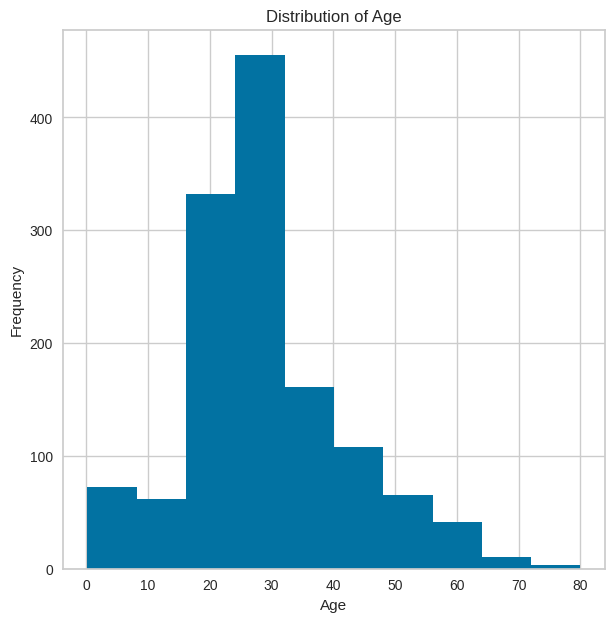

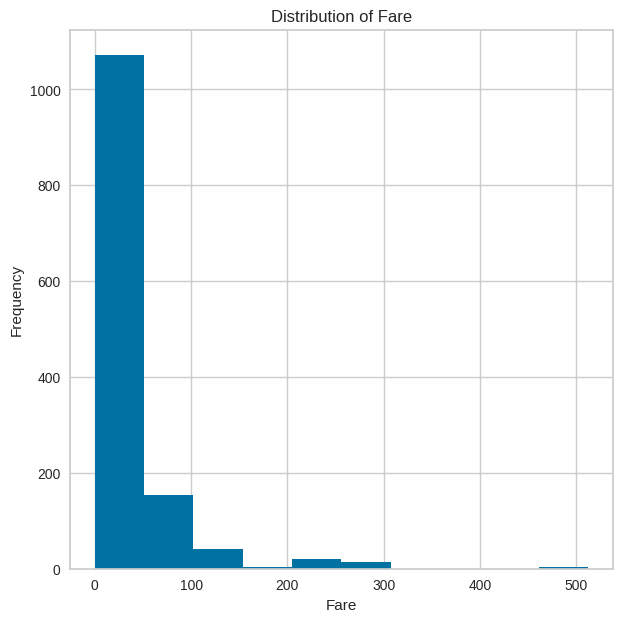

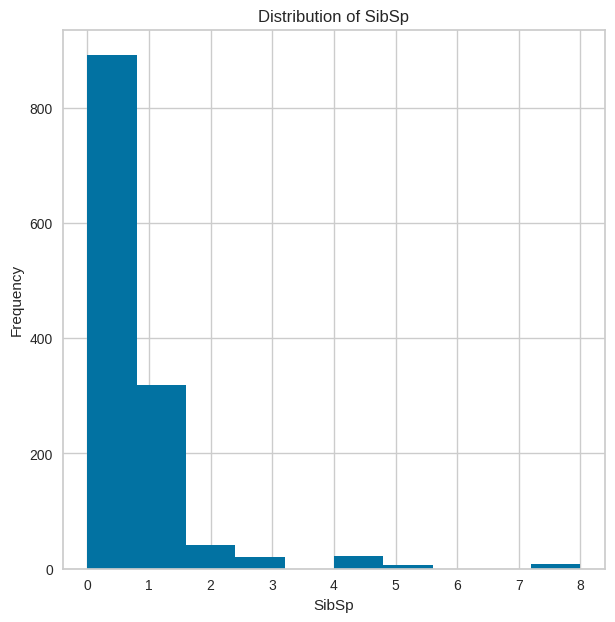

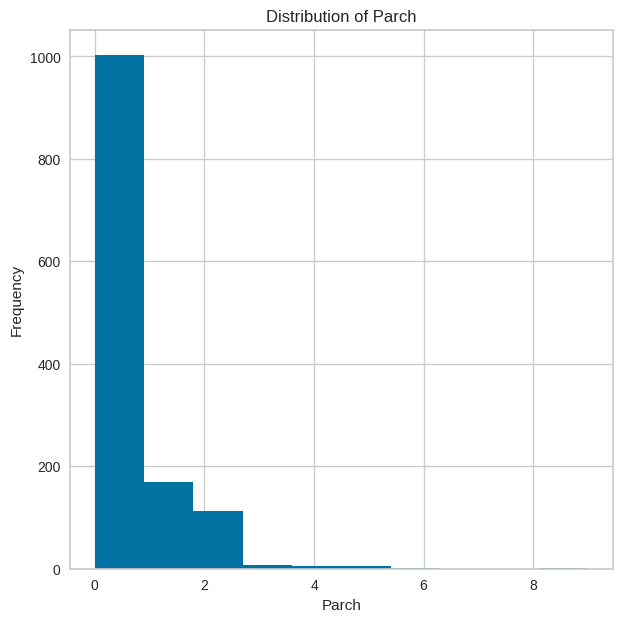

In [48]:
#check the distribution of numerical columns to determine the best scaling method

for i in ['Age','Fare','SibSp','Parch']:
  plt.figure(figsize = (7,7))
  data[i].hist()
  # add labels and title
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.title('Distribution of ' + i)
  plt.show()
  print('')

In [49]:
#RobustScaler seems appropriate because of the heavily skewed distribution
rb = RobustScaler()
cols = ['Age', 'Fare']

for i in cols:
  data[(i+'_scaled')] = rb.fit_transform(data[i].values.reshape(-1,1))

data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc,Age_scaled,Fare_scaled
0,0.0,3,22.0,1,0,7.2500,5,1,0,0,1.0,2,100,12,5,8,-0.500000,-0.308146
1,1.0,1,38.0,1,0,71.2833,4,0,0,0,0.0,0,182,13,22,2,0.642857,2.430755
2,1.0,3,26.0,0,0,7.9250,7,1,0,0,0.0,2,329,9,44,8,-0.214286,-0.279274
3,1.0,1,35.0,1,0,53.1000,6,0,0,0,0.0,2,267,13,20,2,0.428571,1.652999
4,0.0,3,35.0,0,0,8.0500,6,1,0,0,1.0,2,15,12,20,8,0.428571,-0.273927


In [50]:
#dropping preprocessed columns
data = data.drop(columns = cols)
data.head()

,Survived,Pclass,SibSp,Parch,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc,Age_scaled,Fare_scaled
0,0.0,3,1,0,5,1,0,0,1.0,2,100,12,5,8,-0.500000,-0.308146
1,1.0,1,1,0,4,0,0,0,0.0,0,182,13,22,2,0.642857,2.430755
2,1.0,3,0,0,7,1,0,0,0.0,2,329,9,44,8,-0.214286,-0.279274
3,1.0,1,1,0,6,0,0,0,0.0,2,267,13,20,2,0.428571,1.652999
4,0.0,3,0,0,6,1,0,0,1.0,2,15,12,20,8,0.428571,-0.273927


In [51]:
#getting the main datasets for further processing -- avoiding null values in "Survived"
X = data.iloc[:-418]
X.head()

,Survived,Pclass,SibSp,Parch,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc,Age_scaled,Fare_scaled
0,0.0,3,1,0,5,1,0,0,1.0,2,100,12,5,8,-0.500000,-0.308146
1,1.0,1,1,0,4,0,0,0,0.0,0,182,13,22,2,0.642857,2.430755
2,1.0,3,0,0,7,1,0,0,0.0,2,329,9,44,8,-0.214286,-0.279274
3,1.0,1,1,0,6,0,0,0,0.0,2,267,13,20,2,0.428571,1.652999
4,0.0,3,0,0,6,1,0,0,1.0,2,15,12,20,8,0.428571,-0.273927


In [52]:
#getting the target
y = X['Survived']
X = X.drop(columns = ['Survived'])

print('Columns for X_train:', X.columns)

Columns for X_train: Index(['Pclass', 'SibSp', 'Parch', 'Suffix_enc', 'Impute Cabin?',
       'Impute Age?', 'Children?', 'Sex_male', 'Embarked_enc', 'Last Name_enc',
       'Title_enc', 'Tix_Prefix_enc', 'Deck_enc', 'Age_scaled', 'Fare_scaled'],
      dtype='object')


In [53]:
#getting the dataset for submission
X_final = data.iloc[-418:]
X_final.head()

,Survived,Pclass,SibSp,Parch,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc,Age_scaled,Fare_scaled
891,NaN,3,0,0,6,1,0,0,1.0,1,401,12,20,8,0.392857,-0.283372
892,NaN,3,1,0,6,1,0,0,0.0,2,846,13,20,8,1.285714,-0.318839
893,NaN,2,0,0,6,1,0,0,1.0,1,552,12,20,8,2.357143,-0.203886
894,NaN,3,0,0,6,1,0,0,1.0,2,854,12,20,8,-0.142857,-0.247729
895,NaN,3,1,1,7,1,0,0,0.0,2,342,13,20,8,-0.500000,-0.092676


In [54]:
#reset index
X_final = X_final.reset_index()
X_final = X_final.drop(columns = ['Survived', 'index'])

In [55]:
#check the submission dataset
X_final.shape

(418, 15)

## Check for Class Imbalances
No major imbalances need addressing.

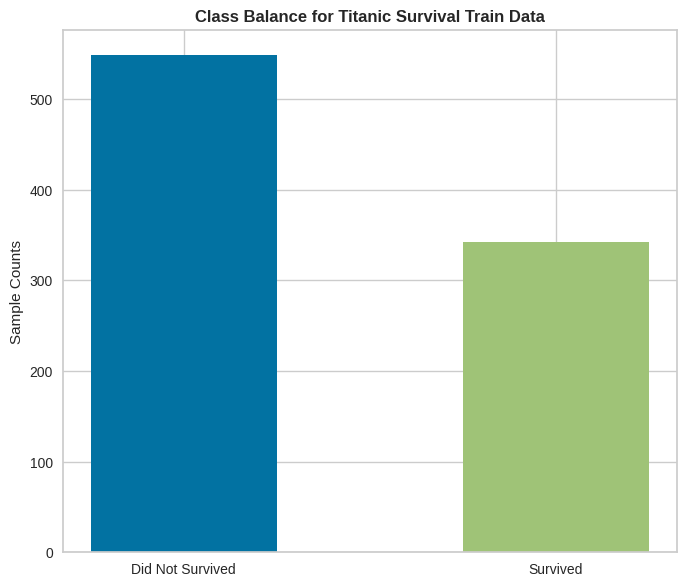

In [56]:
#initializing subplots
fig, ax = plt.subplots(figsize = (7,6))
class_labels = ['Did Not Survived', 'Survived']

#initializing the visualizer
visualizer = ClassBalance(labels=class_labels,ax=ax)
visualizer.fit(y)

#change visualizer details
ax.set_title("Class Balance for Titanic Survival Train Data", fontweight="bold")
ax.set_xticks([0,1])
ax.set_xticklabels(class_labels)
ax.set_ylabel("Sample Counts")

#plot the class imbalance
plt.tight_layout(pad=1)
plt.show()

## Principle Component Methods
Dimensionality reduction techniques might help improve the dataset. Since we have mixed data, I'll try Prince's FAMD. PCA visualizer by yellowbrick might provide interesting insights on the direction of the features.



---


Update: PCA did not improve results. I will comment out this section.

In [57]:
# #initial visualizer
# visualizer = PCA_viz(
#     proj_features=True,
#     size = (1920,1080),
#     colors= '#D4D4D4'
#     )
# visualizer.fit_transform(X)
# visualizer.show()

> One way to improve performance might be to remove cols = ['Tix_Prefix_enc', 'Last Name_enc']

In [58]:
# cols = ['Tix_Prefix_enc','Last Name_enc']

# X = X.drop(columns = cols)
# X_final = X_final.drop(columns = cols)

In [59]:
# #initialize FAMD
# famd = FAMD(
#     n_components=20,
#     n_iter=3,
#     copy=True,
#     check_input=True,
#     engine="sklearn",
#     handle_unknown="error"
# )

# #fit the data
# famd.fit(X)

In [60]:
# famd.eigenvalues_summary

In [61]:
# famd.scree_plot()

In [62]:
# n = 10

# famd = FAMD(n_components = 10)

# #fit and transform X to get the principal components from PCA
# X_pca = pd.DataFrame(famd.fit_transform(X))
# X_pca

In [63]:
# n = 10

# famd = FAMD(n_components = n)

# #fit and transform X to get the principal components from PCA
# X_final_pca = pd.DataFrame(famd.fit_transform(X_final))
# X_final_pca

## Splitting into Train and Test

In [64]:
#choosing a seed
seed = 10

#splitting X into train and test datasets for better training of the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

X_train.tail()

,Pclass,SibSp,Parch,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc,Age_scaled,Fare_scaled
369,1,0,0,4,0,0,0,0.0,0,39,11,22,1,-0.357143,2.345923
320,3,0,0,5,1,0,0,1.0,2,204,12,5,8,-0.500000,-0.308146
527,1,0,0,4,0,1,0,1.0,2,245,12,22,2,0.112857,8.867925
125,3,1,0,3,1,0,1,1.0,0,569,8,20,8,-1.214286,-0.137408
265,2,0,0,4,1,0,0,1.0,2,657,12,12,8,0.500000,-0.169133


# **Modeling**
- Define a modeling pipeline
- Incorporate metrics
- Model
- Hypertuning parameters

In [117]:
def modeling(model):

  #fitting the model
  model.fit(X_train, y_train)

  #making predictions
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  #getting performance matrices
  cm = confusion_matrix(y_test, y_pred_test)
  auc = roc_auc_score(y_test, y_pred_test)
  acc_train = model.score(X_train, y_train)
  acc_test = model.score(X_test, y_test)

  #initializing the ConfusionMatrixDisplay matrix
  confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels)

  #ploting the confusion_matrix_display
  confusion_matrix_display.plot()
  plt.grid(False)

  #priting the classification report
  print(classification_report(y_test, y_pred_test,  target_names = class_labels))
  print('AUC Score: ', auc, '\n')

  return auc, acc_train, acc_test

In [66]:
def hypertuning(model, parameters):

  #initializing gridsearch
  gridsearch = GridSearchCV(estimator=model, param_grid=parameters, scoring='roc_auc', cv=10)

  #training grid search
  gridsearch.fit(X_train, y_train)

  #getting the best model
  model_finetuned = gridsearch.best_estimator_

  #getting predictions
  y_pred_train_finetuned = model_finetuned.predict(X_train)
  y_pred_test_finetuned = model_finetuned.predict(X_test)

  #getting accuracy scores
  accuracy_train_finetuned = model_finetuned.score(X_train, y_train)
  accuracy_test_finetuned = model_finetuned.score(X_test, y_test)

  #printing results
  print('Best parameters: ', gridsearch.best_params_)
  print('Fine-tuned accuracy score (train): ', accuracy_train_finetuned)
  print('Fine-tuned accuracy score (test): ', accuracy_test_finetuned)

  return model_finetuned

##Logistics Regression

                  precision    recall  f1-score   support

Did Not Survived       0.85      0.88      0.87       147
        Survived       0.75      0.71      0.73        76

        accuracy                           0.82       223
       macro avg       0.80      0.79      0.80       223
    weighted avg       0.82      0.82      0.82       223

AUC Score:  0.7940386680988184 



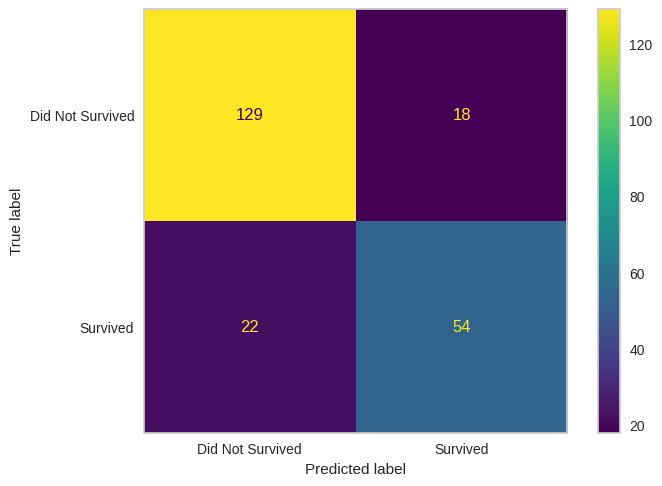

In [118]:
auc_lr, acc_train_lr, acc_test_lr = modeling(LogisticRegression(random_state=seed, max_iter=5000))

In [68]:
#creating parameters dict
parameters =  {
    'penalty' : ['l1', 'l2'],
    'C' : [0.01,0.05,0.1, 1.5],
    'solver' : ['saga','liblinear'],
}

best_lr = hypertuning(LogisticRegression(random_state = seed, max_iter=10000), parameters)

Best parameters:  {'C': 1.5, 'penalty': 'l1', 'solver': 'liblinear'}
Fine-tuned accuracy score (train):  0.8053892215568862
Fine-tuned accuracy score (test):  0.8251121076233184


                  precision    recall  f1-score   support

Did Not Survived       0.85      0.89      0.87       147
        Survived       0.77      0.70      0.73        76

        accuracy                           0.83       223
       macro avg       0.81      0.79      0.80       223
    weighted avg       0.82      0.83      0.82       223

AUC Score:  0.7942624418188327 



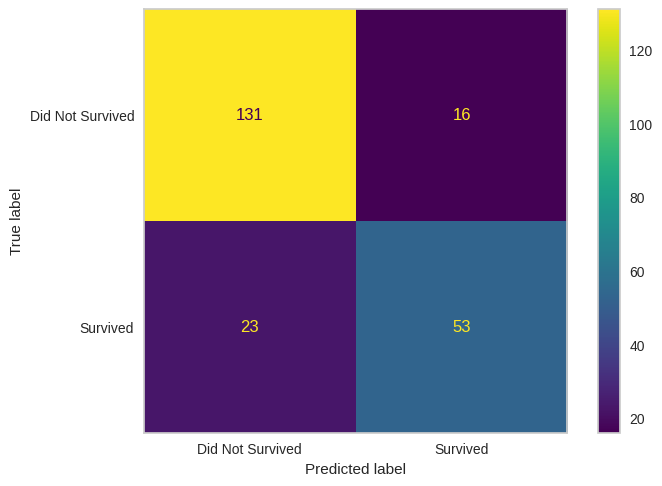

In [119]:
auc_lr, acc_train_lr, acc_test_lr = modeling(best_lr)

## Gaussian NB


                  precision    recall  f1-score   support

Did Not Survived       0.82      0.85      0.84       147
        Survived       0.69      0.64      0.67        76

        accuracy                           0.78       223
       macro avg       0.76      0.75      0.75       223
    weighted avg       0.78      0.78      0.78       223

AUC Score:  0.7475384890798425 



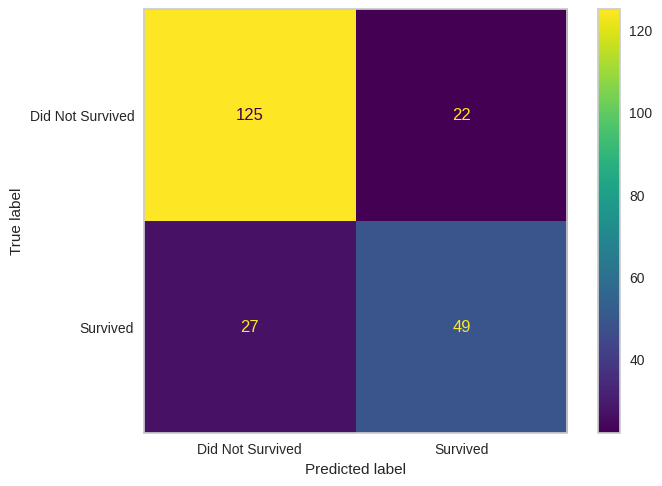

In [120]:
auc_gnb, acc_train_gnb, acc_test_gnb = modeling(GaussianNB())

## KNeighbors Classifier

                  precision    recall  f1-score   support

Did Not Survived       0.74      0.74      0.74       147
        Survived       0.49      0.49      0.49        76

        accuracy                           0.65       223
       macro avg       0.61      0.61      0.61       223
    weighted avg       0.65      0.65      0.65       223

AUC Score:  0.6141693519513068 



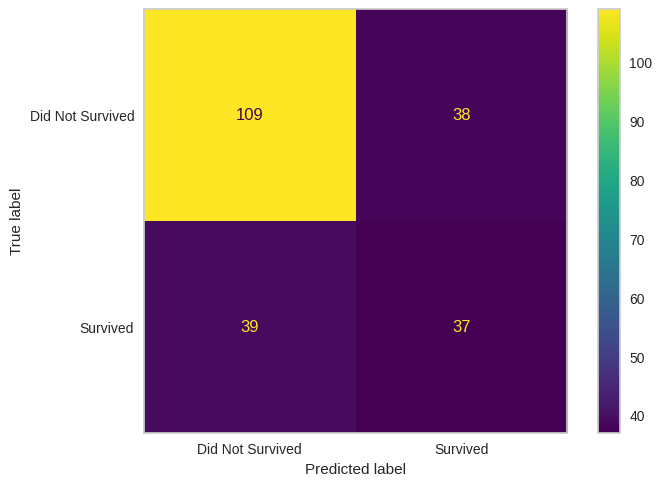

In [121]:
auc_knn, acc_train_knn, acc_test_knn = modeling(KNeighborsClassifier())

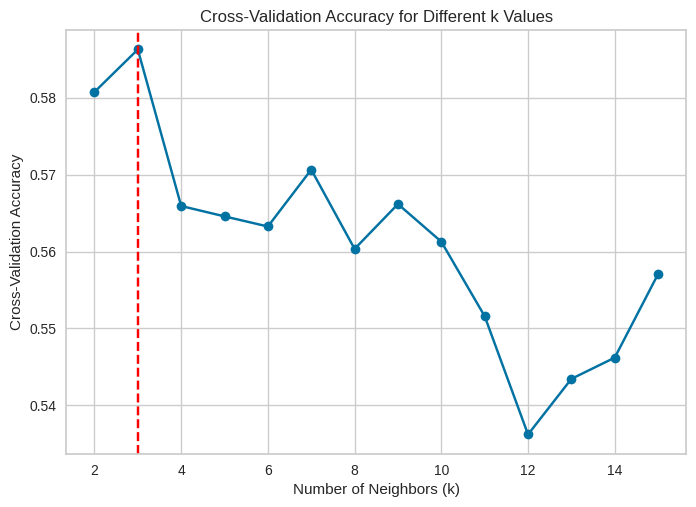

In [72]:
scores = []
k_values = [i for i in range(2,16)]

#Initializing a new model
model = KNeighborsClassifier()

#Iterating from each k
for k in k_values:

    #setting up the model with k
    model.set_params(n_neighbors = k)

    #caculating recall
    score = np.mean(cross_val_score(model, X_train.values, y_train, cv=10, scoring = 'roc_auc'))

    #adding result to recall list
    scores.append(score)

#getting the best k (adding 2 since interation starts with 2)
best_k = scores.index(np.max(scores)) + 2

#plotting recall scores for different k values
plt.plot(k_values, scores, marker = 'o')

#adding the line that indicates best k
plt.axvline(x = best_k, linestyle = '--', color='red')

#adding titles and labels for the plot
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy for Different k Values')
plt.grid(True)

#displaying the graph
plt.show()

                  precision    recall  f1-score   support

Did Not Survived       0.71      0.75      0.73       147
        Survived       0.45      0.39      0.42        76

        accuracy                           0.63       223
       macro avg       0.58      0.57      0.57       223
    weighted avg       0.62      0.63      0.62       223

AUC Score:  0.5715180809165772 



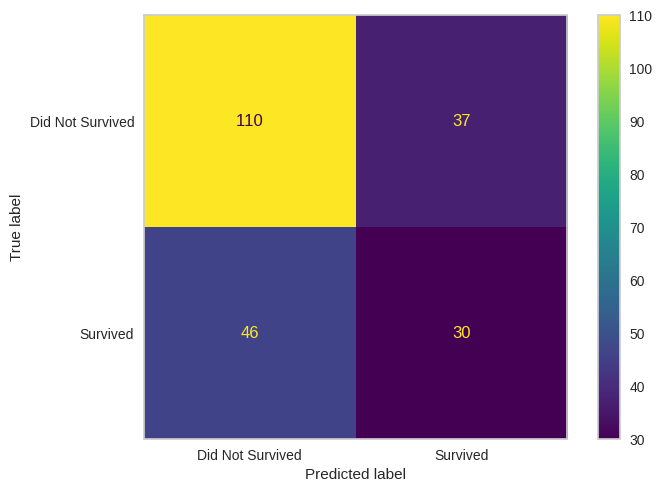

In [122]:
auc_knn, acc_train_knn, acc_test_knn = modeling(KNeighborsClassifier(n_neighbors=best_k))

## Simple Decision Tree

                  precision    recall  f1-score   support

Did Not Survived       0.83      0.80      0.81       147
        Survived       0.63      0.68      0.66        76

        accuracy                           0.76       223
       macro avg       0.73      0.74      0.74       223
    weighted avg       0.76      0.76      0.76       223

AUC Score:  0.7400644468313641 



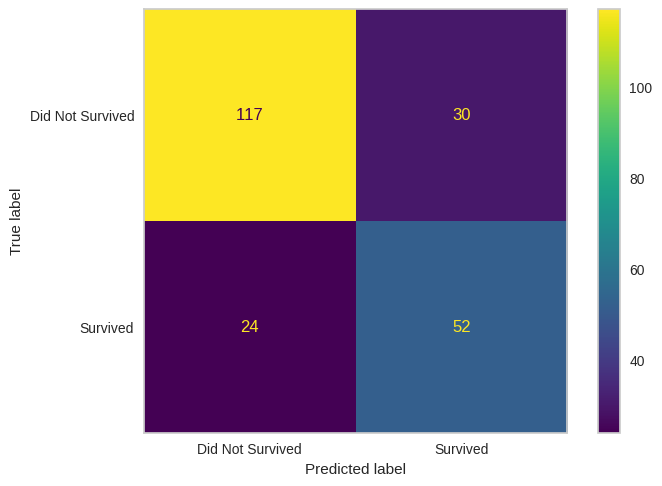

In [123]:
auc_dt, acc_train_dt, acc_test_dt = modeling(DecisionTreeClassifier(random_state=seed))

In [75]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 10, 20],
    'max_features': ['sqrt','log2']
}

best_dt = hypertuning(DecisionTreeClassifier(random_state=seed), param_grid)

Best parameters:  {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 20}
Fine-tuned accuracy score (train):  0.8637724550898204
Fine-tuned accuracy score (test):  0.8475336322869955


                  precision    recall  f1-score   support

Did Not Survived       0.88      0.89      0.89       147
        Survived       0.78      0.76      0.77        76

        accuracy                           0.85       223
       macro avg       0.83      0.83      0.83       223
    weighted avg       0.85      0.85      0.85       223

AUC Score:  0.827157178660938 



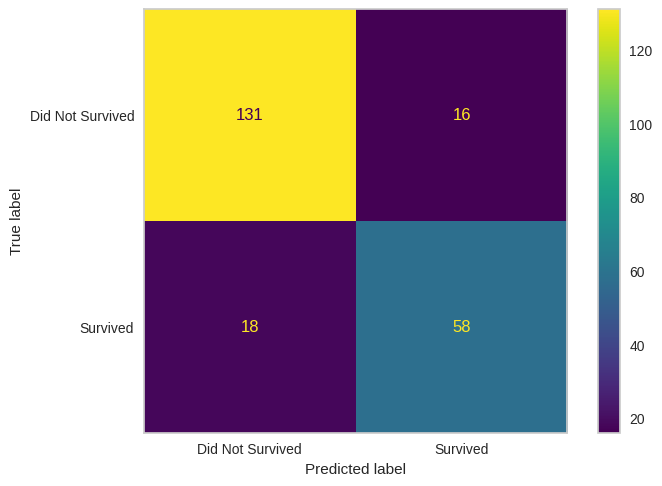

In [124]:
auc_dt, acc_train_dt, acc_test_dt = modeling(best_dt)

## RandomForest

                  precision    recall  f1-score   support

Did Not Survived       0.88      0.92      0.90       147
        Survived       0.83      0.76      0.79        76

        accuracy                           0.87       223
       macro avg       0.86      0.84      0.85       223
    weighted avg       0.86      0.87      0.86       223

AUC Score:  0.8407626208378087 



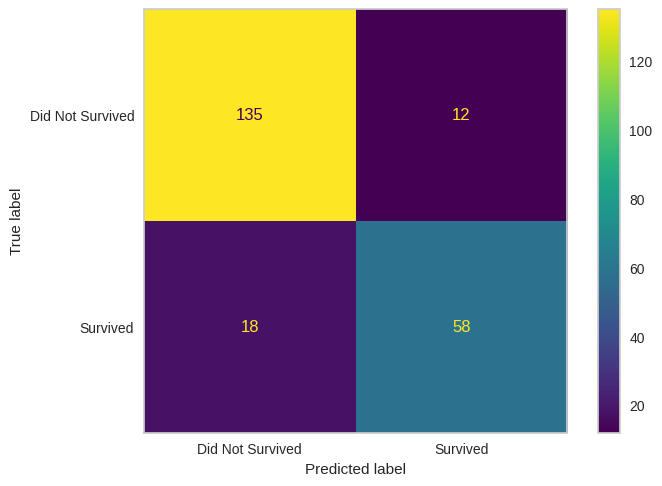

In [125]:
auc_rf, acc_train_rf, acc_test_rf = modeling(RandomForestClassifier(random_state=seed))

In [78]:
#creating parameters dict
param_grid = {
    'max_features': ['sqrt','log2'],
    'min_samples_split': [2, 10, 15],
    'n_estimators': [5, 100, 200, 500]
}


best_rf = hypertuning(RandomForestClassifier(random_state=seed), param_grid)

Best parameters:  {'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 500}
Fine-tuned accuracy score (train):  0.9116766467065869
Fine-tuned accuracy score (test):  0.8609865470852018


                  precision    recall  f1-score   support

Did Not Survived       0.87      0.93      0.90       147
        Survived       0.85      0.72      0.78        76

        accuracy                           0.86       223
       macro avg       0.86      0.83      0.84       223
    weighted avg       0.86      0.86      0.86       223

AUC Score:  0.8278284998209812 



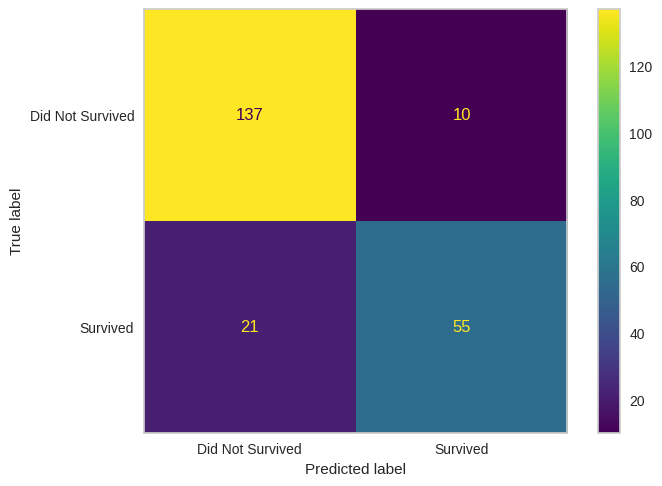

In [126]:
auc_rf, acc_train_rf, acc_test_rf = modeling(best_rf)

## AdaBoost Classifier

                  precision    recall  f1-score   support

Did Not Survived       0.89      0.86      0.88       147
        Survived       0.75      0.80      0.78        76

        accuracy                           0.84       223
       macro avg       0.82      0.83      0.83       223
    weighted avg       0.85      0.84      0.84       223

AUC Score:  0.8332885785893305 



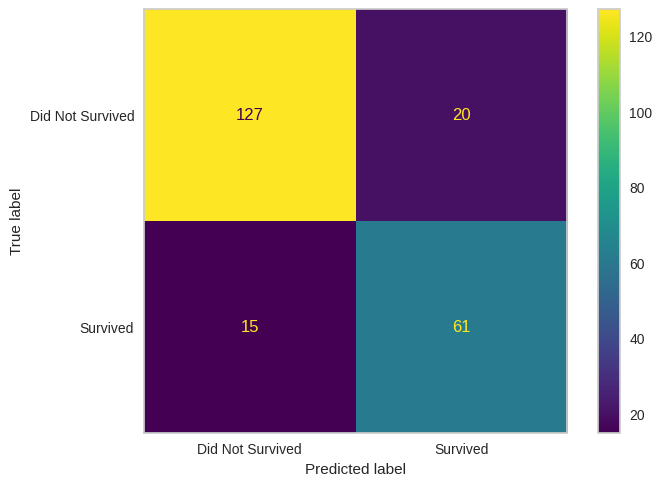

In [127]:
auc_abc, acc_train_abc, acc_test_abc = modeling(AdaBoostClassifier())

In [107]:
parameters = {
    'learning_rate':[0.01*i for i in range(11)],
    'n_estimators':[100,150,200,250]
}

best_abc = hypertuning(AdaBoostClassifier(), parameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/skl

Best parameters:  {'learning_rate': 0.1, 'n_estimators': 250}
Fine-tuned accuracy score (train):  0.8383233532934131
Fine-tuned accuracy score (test):  0.8475336322869955


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/skl

Best parameters:  {'learning_rate': 0.04, 'n_estimators': 250}
Fine-tuned accuracy score (train):  0.8173652694610778
Fine-tuned accuracy score (test):  0.852017937219731


                  precision    recall  f1-score   support

Did Not Survived       0.89      0.89      0.89       147
        Survived       0.79      0.78      0.78        76

        accuracy                           0.85       223
       macro avg       0.84      0.83      0.83       223
    weighted avg       0.85      0.85      0.85       223

AUC Score:  0.8337361260293591 



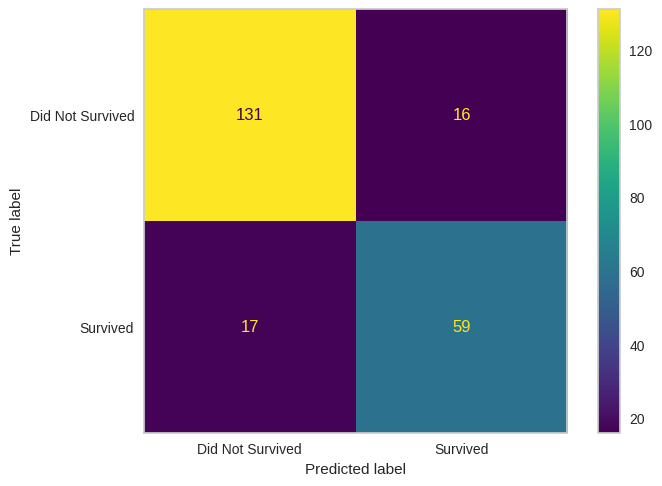

In [128]:
auc_abc, acc_train_abc, acc_test_abc = modeling(best_abc)

## SVC - Support Vector Machines

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

Did Not Survived       0.66      1.00      0.79       147
        Survived       0.00      0.00      0.00        76

        accuracy                           0.66       223
       macro avg       0.33      0.50      0.40       223
    weighted avg       0.43      0.66      0.52       223

AUC Score:  0.5 



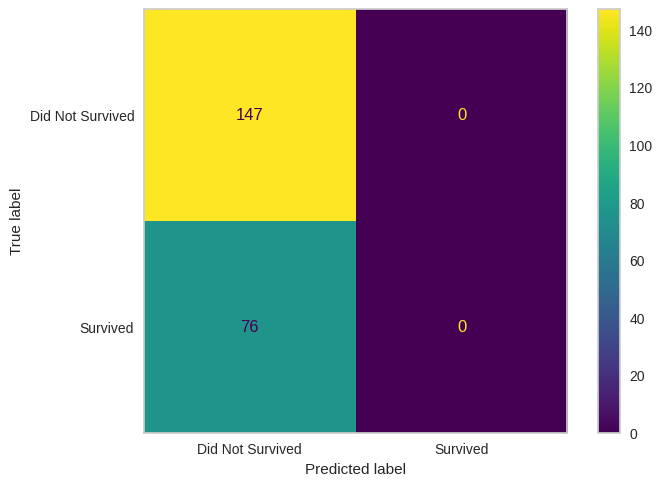

In [129]:
auc_svc, acc_train_svc, acc_test_svc = modeling(SVC(random_state=seed))

In [84]:
parameters = {
    'C': [0.01, 0.1, 1.0, 10],
    'kernel' : ['poly', 'rbf'],
    'degree' : [1,2,3],
}

best_svc = hypertuning(SVC(random_state=seed), parameters)


Best parameters:  {'C': 10, 'degree': 1, 'kernel': 'poly'}
Fine-tuned accuracy score (train):  0.6017964071856288
Fine-tuned accuracy score (test):  0.6591928251121076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

Did Not Survived       0.66      1.00      0.79       147
        Survived       0.00      0.00      0.00        76

        accuracy                           0.66       223
       macro avg       0.33      0.50      0.40       223
    weighted avg       0.43      0.66      0.52       223

AUC Score:  0.5 



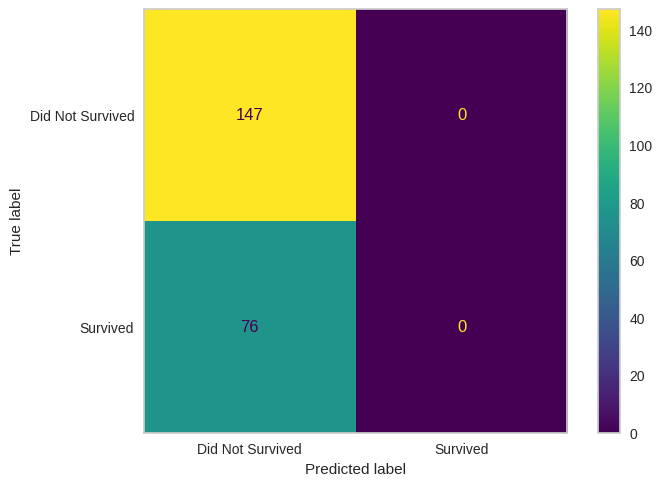

In [130]:
auc_svc, acc_train_svc, acc_test_svc = modeling(best_svc)

## GradientBoostingClassifier

                  precision    recall  f1-score   support

Did Not Survived       0.87      0.92      0.89       147
        Survived       0.82      0.74      0.78        76

        accuracy                           0.86       223
       macro avg       0.85      0.83      0.84       223
    weighted avg       0.85      0.86      0.85       223

AUC Score:  0.8276047261009668 



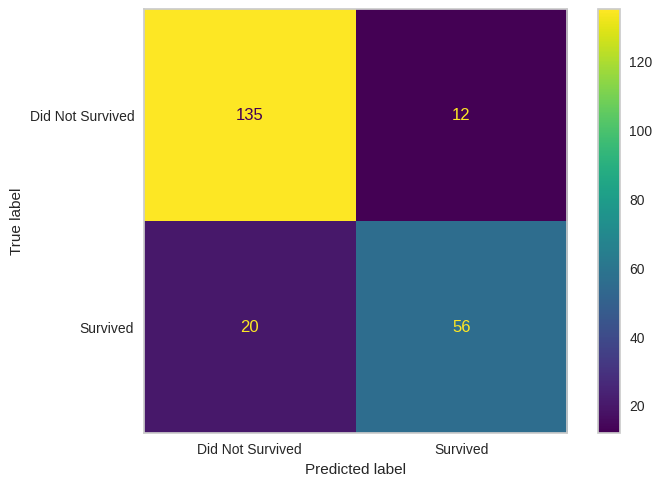

In [131]:
auc_gbc, acc_train_gbc, acc_test_gbc = modeling(GradientBoostingClassifier(random_state=seed))

In [112]:
param_grid = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate':[0.01*i for i in range(11)],
    'n_estimators':[100,150,200,300]
}

best_gbc = hypertuning(GradientBoostingClassifier(random_state=seed), param_grid)

Best parameters:  {'learning_rate': 0.07, 'loss': 'log_loss', 'n_estimators': 100}
Fine-tuned accuracy score (train):  0.8877245508982036
Fine-tuned accuracy score (test):  0.852017937219731


                  precision    recall  f1-score   support

Did Not Survived       0.86      0.93      0.89       147
        Survived       0.83      0.71      0.77        76

        accuracy                           0.85       223
       macro avg       0.85      0.82      0.83       223
    weighted avg       0.85      0.85      0.85       223

AUC Score:  0.8178481919083423 



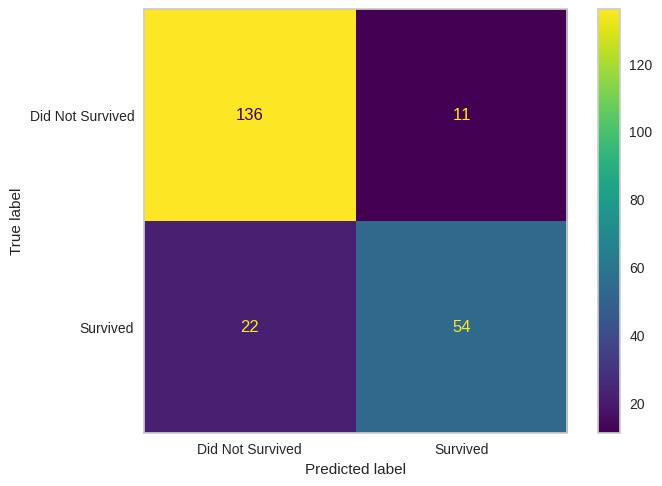

In [132]:
auc_gbc, acc_train_gbc, acc_test_gbc = modeling(best_gbc)

## MLPC - Neural Networks

                  precision    recall  f1-score   support

Did Not Survived       0.88      0.81      0.84       147
        Survived       0.68      0.79      0.73        76

        accuracy                           0.80       223
       macro avg       0.78      0.80      0.79       223
    weighted avg       0.81      0.80      0.81       223

AUC Score:  0.7994987468671679 



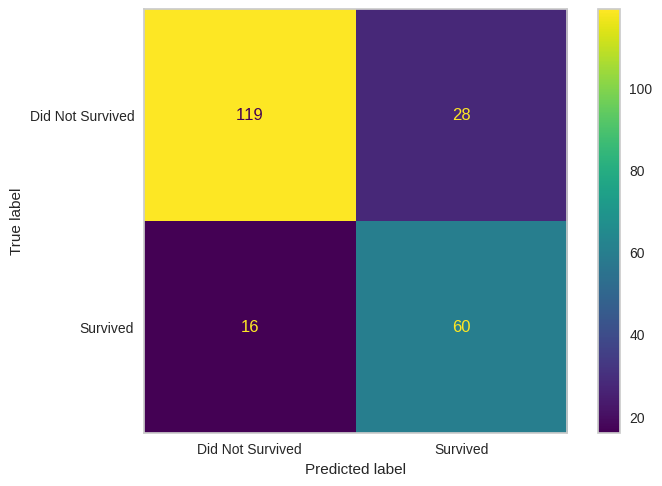

In [133]:
auc_mlpc, acc_train_mlpc, acc_test_mlpc = modeling(MLPClassifier(random_state=seed, max_iter=10000))

In [90]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

best_mlpc = hypertuning(MLPClassifier(random_state=seed, max_iter=10000), param_grid)

Best parameters:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Fine-tuned accuracy score (train):  0.7799401197604791
Fine-tuned accuracy score (test):  0.7802690582959642


                  precision    recall  f1-score   support

Did Not Survived       0.82      0.85      0.84       147
        Survived       0.69      0.64      0.67        76

        accuracy                           0.78       223
       macro avg       0.76      0.75      0.75       223
    weighted avg       0.78      0.78      0.78       223

AUC Score:  0.7475384890798425 



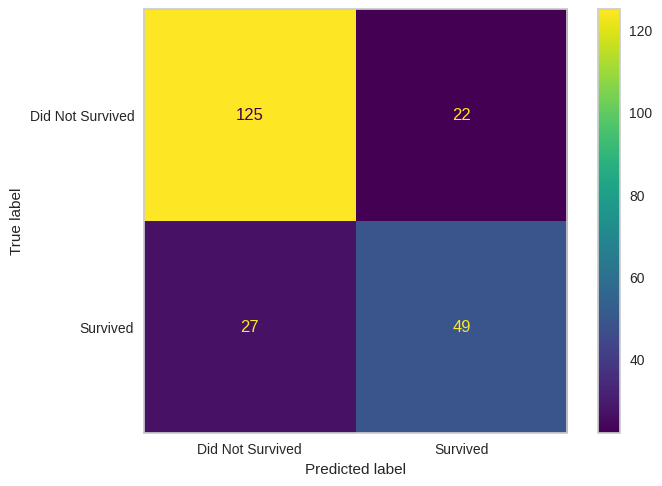

In [134]:
auc_mlpc, acc_train_mlpc, acc_test_mlpc = modeling(best_mlpc)

# Final Predictions
- Compare between models
- Choose a final model
- Predict on the submission csv
- Extract results

In [136]:
table = pd.DataFrame({
    'Models' : ['LogisticsRegression', 'GaussianNB', 'KNeighbors Classifier', 'Decision Tree', 'RandomForest', 'AdaBoost', 'SVC - Support Vector Machines', 'GradientBoosting', 'MLPC - Neural Network'],
    'AUC Scores':[auc_lr, auc_gnb, auc_knn, auc_dt, auc_rf, auc_abc, auc_svc, auc_gbc, auc_mlpc],
    'Accuracy Train Scores' : [acc_train_lr, acc_train_gnb, acc_train_knn, acc_train_dt, acc_train_rf, acc_train_abc, acc_train_svc, acc_train_gbc, acc_train_mlpc],
    'Accuracy Test Scores':[acc_test_lr, acc_test_gnb, acc_test_knn, acc_test_dt,acc_test_rf, acc_test_abc,acc_test_svc, acc_test_gbc, acc_test_mlpc]
}
)
table

,Models,AUC Scores,Accuracy Train Scores,Accuracy Test Scores
0,LogisticsRegression,0.794262,0.805389,0.825112
1,GaussianNB,0.747538,0.742515,0.780269
2,KNeighbors Classifier,0.571518,0.794910,0.627803
3,Decision Tree,0.827157,0.863772,0.847534
4,RandomForest,0.827828,0.911677,0.860987
5,AdaBoost,0.833736,0.817365,0.852018
6,SVC - Support Vector Machines,0.500000,0.601796,0.659193
7,GradientBoosting,0.817848,0.887725,0.852018
8,MLPC - Neural Network,0.747538,0.779940,0.780269


In [93]:
#choosing random forest and make predictions on submission data
final_model = best_rf

final_model.fit(X_train,y_train)
y_pred_train = final_model.predict(X_train)
y_pred_final = final_model.predict(X_final)

result = pd.concat([data_test['PassengerId'], pd.Series(y_pred_final,name = 'Survived')], axis=1)

result.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [94]:
#changing to the appropriate type
result['Survived'] = result['Survived'].astype(int)

In [95]:
#extracting results
result.to_csv('submission.csv', index=False)

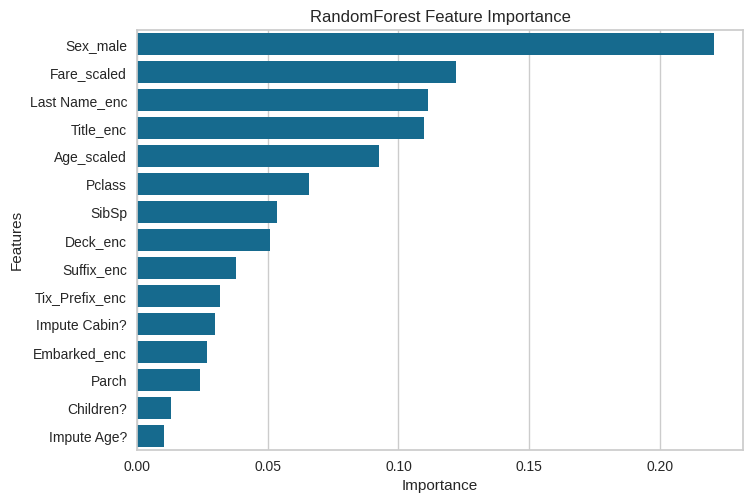

In [96]:
# examining feature importances for more insights
importance = pd.DataFrame(data = {'Importance' : final_model.feature_importances_, 'Features': X.columns})
sns.barplot(data=importance, x='Importance', y='Features', order = importance.sort_values('Importance', ascending=False).Features).set(title='RandomForest Feature Importance')

plt.tight_layout(pad = 2)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


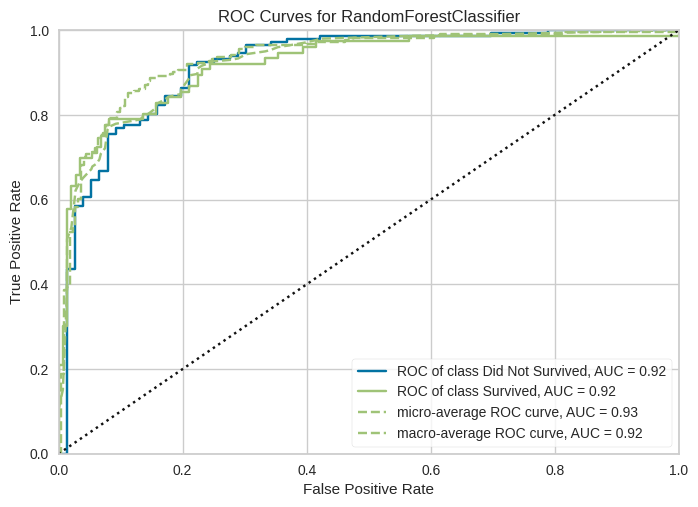

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [97]:
#see the ROC-AUC curve
visualizer = ROCAUC(final_model, classes= class_labels)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# **Decisions Made**
1. Splitted 'Name' into 'Title', 'First Name', and 'Last Name' to then delete 'Name'.
2. Deleted 'First Name' because it likely does not influence survival rate and is difficult to encode.
3. Splitted 'Ticket' into 'Tix_Prefix' and 'Tix_Suffix' to then delete 'Ticket' and 'Tix_Suffix'. Should consider unsupervised learning with 'Tix_Suffix'.
4. Imputed the missing cabins with 'Z', added imputation column.
5. Extracted the first letter of the cabin name as 'Deck' then deleted 'Cabin'.
6. Added a column that identified children amongst the passengers.
7. Used RobustScaling for 'Age' and 'Fare' but not other columns.
8. Decided to not address class imbalances -- not a major imbalance.
9. Used scoring = 'roc_auc' when tuning instead of 'accuracy' because accuracy is not a reliable metrics. Got higher scores with the submission dataset when tuning parameters with roc_auc
10. Chose a random_state = seed = 10. Worked better than another seed = 42.
11. Tried PCA and FAMD (a factor analysis library from Prince that handles mixed data) but got worse results.
12. Focus on hypertuning RandomForest for the best results instead of running all models.

# **Notes**
1. The titanic sank in 1912 and was a ship of the United Kingdom at the time. The average marriage age at this time for women was 24.5 years old and for men was 25.9 years old: https://blog.datawrapper.de/historical-marriage-age-britain/
2. The titanic has different levels and decks containing the cabins. The decks are coded from 'A' to 'G': https://rmstitanic1912.weebly.com/the-levels-of-the-titanic.html
3. 'Ms.' is typically for older unmarried women while 'Miss' is more common for young women and girls: https://www.scribbr.co.uk/strong-communication/miss-mrs-ms/#:~:text=Miss%20is%20a%20title%20used,adult%20woman%20with%20Ms%20instead
4. The title 'Master' is traditionally used as a title for young boys under the age of 18: https://promova.com/confusing-words/master-mister.
5. While it is unclear how long it took to obtain a medical degree at this time, I found an example from the first women to became a physician in the UK, Elizabeth Blackwell. She was born in 1821 and became a doctor in 1849, which made her 28: https://www.womenshistory.org/education-resources/biographies/elizabeth-blackwell
6. In the UK, the age of consent for children increased from 13 to 16 from 1880 to 1920. I used the middle, which is 14.5 or 15 as the age to classify children among the passengers.

# **Next Steps to Improve the Best Model**

- Reconsider cleaning decisions with the best mdodel
- Hypertune with more robust options

In [98]:
print('Parameters of Final Model:', final_model.get_params)
print('ROC-AUC Score:', auc_rf)
print('Accuracy Score - Train:', final_model.score(X_train, y_train))
print('Accuracy Score - Test:', final_model.score(X_test, y_test))

Final Model: Random Forest Classifier
Parameters of Final Model: <bound method BaseEstimator.get_params of RandomForestClassifier(min_samples_split=10, n_estimators=500, random_state=10)>
ROC-AUC Score: 0.8278284998209812
Accuracy Score - Train: 0.9116766467065869
Accuracy Score - Test: 0.8609865470852018


In [108]:
# #extracting X and X_final for quick analysis in the future
# X.to_csv('X.csv', index=False)
# X_final.to_csv('X_final.csv', index=False)

## Reloading the project
- Run the first 3 cells in ' Initial Analysis'
- Run the 2 cells in 'Modeling'
- Run the rest in this subsection

In [109]:
X = pd.read_csv('X.csv')
X_final = pd.read_csv('X_final.csv')

In [110]:
X.head()

,Pclass,SibSp,Parch,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc,Age_scaled,Fare_scaled
0,3,1,0,5,1,0,0,1.0,2,100,12,5,8,-0.500000,-0.308146
1,1,1,0,4,0,0,0,0.0,0,182,13,22,2,0.642857,2.430755
2,3,0,0,7,1,0,0,0.0,2,329,9,44,8,-0.214286,-0.279274
3,1,1,0,6,0,0,0,0.0,2,267,13,20,2,0.428571,1.652999
4,3,0,0,6,1,0,0,1.0,2,15,12,20,8,0.428571,-0.273927


In [111]:
X_final.tail()

,Pclass,SibSp,Parch,Suffix_enc,Impute Cabin?,Impute Age?,Children?,Sex_male,Embarked_enc,Last Name_enc,Title_enc,Tix_Prefix_enc,Deck_enc,Age_scaled,Fare_scaled
413,3,0,0,3,1,1,0,1.0,2,753,12,2,8,0.112857,-0.273927
414,1,0,0,4,0,0,0,0.0,0,593,3,22,2,0.714286,4.039736
415,3,0,0,7,1,0,0,1.0,2,699,12,40,8,0.678571,-0.308146
416,3,0,0,6,1,1,0,1.0,2,827,12,20,8,0.112857,-0.273927
417,3,1,1,3,1,1,0,1.0,0,634,8,20,8,-0.857143,0.338083


In [ ]:
#choosing a seed
seed = 10

#splitting X into train and test datasets for better training of the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

X_train.tail()

## More Robust Hypertuning

In [ ]:
#creating parameters dict
param_grid = {
    'n_estimators': [500, 800, 1000, 1500],
    'criterion': ['gini', 'entropy','log_loss'],
    'min_samples_leaf': [i for i in range(10, 20, 2)],
    'max_features': ['sqrt','log2']

}

best_rf = hypertuning(RandomForestClassifier(random_state=seed, n_jobs=-1), param_grid)

In [ ]:
auc_rf, acc_train_rf, acc_test_rf = modeling(best_rf)